In [15]:
import networkx as nx
import osmnx as ox
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

# Traveling Salesperson Problem
The canonical [Traveling Salesperson Problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem) is stated as:
>  "Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city and returns to the origin city?"

This is generalizable to finding the shortest [Hamiltonian cycle](http://mathworld.wolfram.com/HamiltonianCycle.html) on a fully connected graph (i.e. all nodes can be reached from all other nodes).

This problem is [NP-hard](https://en.wikipedia.org/wiki/P_versus_NP_problem), meaning it is not possible for an algorithm to solve all instances of the problem quickly (i.e. in polynomial time). However, there are many approximate and heuristic approaches which can give reasonable solutions in shorter time.

In [16]:
# we'll be looking at new york city
place_name = 'New York City, NY, United States'

I've already downloaded the roads for NYC and it's hosted on our file server. However, if you wanted to do it for yourself, you can uncomment the next cell. It will take a long time to run, however, since it is a big set of roads.

In [ ]:
# # We can query osm for the roads
# place_roads = ox.graph_from_place(place_name)
# # save graph to file for reuse
# ox.io.save_graphml(place_roads, 'nyc_osmnx.graphml')

In [ ]:
!wget https://files.bwsi-remote-sensing.net/data/nyc_osmnx.graphml

In [17]:
# loading graph from a file, will take a while to run b/c big file
place_roads = ox.io.load_graphml('nyc_osmnx.graphml')

In [18]:
# can convert the graph to geopandas gdfs
# also takes a bit of time to run
place_roads_nodes, place_roads_edges = ox.graph_to_gdfs(place_roads)

<Axes: >

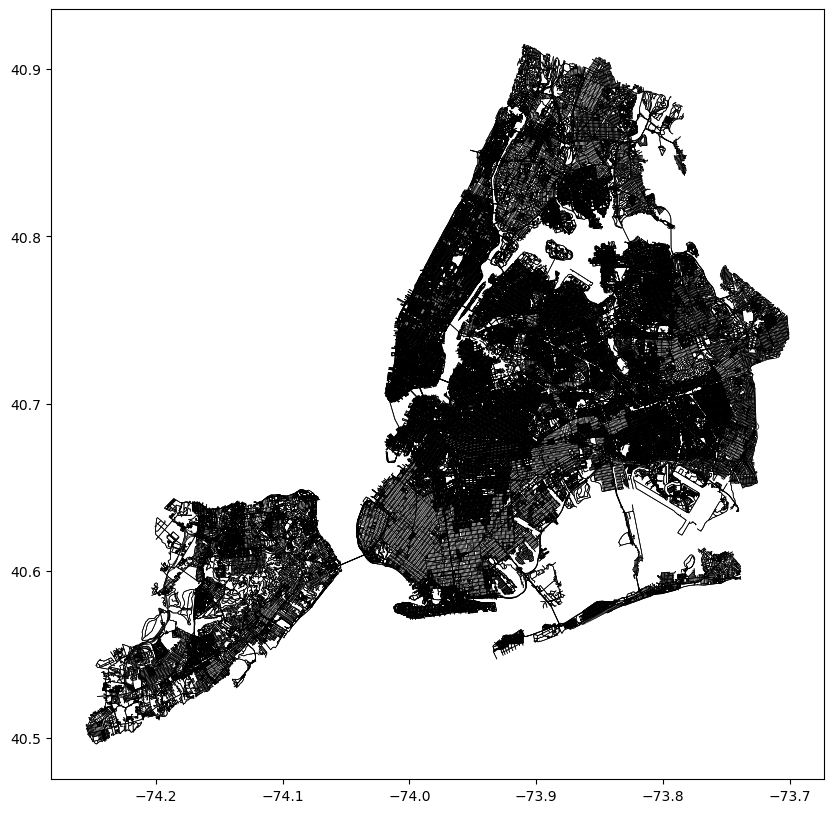

In [19]:
# let's visualize by plotting the road edges
# also takes a bit of time to run
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(1,1,1)
place_roads_edges.plot(ax=ax, color=[0, 0, 0], linewidth=0.5)

Let's say you wanted to do a ice cream crawl: you want to visit every ice cream shop in a city. What is the shortest route that you would take that takes you to every ice cream shop in a city and brings you back to your starting point?

In [ ]:
place_ice_cream = ox.geometries.geometries_from_place(place_name, tags={"amenity":"ice_cream"})

#some of the ice cream shops return polygons instead of points, so we need to take their centroids
place_ice_cream = place_ice_cream.to_crs("epsg:3857") #projecting to Web-Mercator for more accurate centroids
place_ice_cream["geometry"] = place_ice_cream["geometry"].centroid
place_ice_cream = place_ice_cream.to_crs("epsg:4326") #projecting back to lat/long

place_ice_cream

In [ ]:
place_ice_cream

In [ ]:
ice_cream_nodes = ox.distance.nearest_nodes(place_roads, place_ice_cream.geometry.x, place_ice_cream.geometry.y)
ice_cream_nodes

## Compute shortest path matrix

We create a matrix of the shortest paths between each pair of ice cream shops. We only care about the shortest paths between them when figuring out our traveling salesperson tour, because we wouldn't want to take any other path other than the shortest path, since by definition, any other path would be longer.

We create a matrix that has the length of the shortest paths between any pair of ice cream shops below

In [ ]:
# this will take a while to compute!
shortest_path_matrix = np.zeros([len(ice_cream_nodes),len(ice_cream_nodes)])
for idx_i, orig in enumerate(ice_cream_nodes):
    shortest_paths = nx.single_source_dijkstra_path_length(place_roads, orig, weight='length')
    for idx_j, dest in enumerate(ice_cream_nodes):
        shortest_path_matrix[idx_i, idx_j] = shortest_paths[dest]
shortest_path_matrix

We then use the networkx function [from_numpy_array](https://networkx.org/documentation/stable/reference/generated/networkx.convert_matrix.from_numpy_array.html) to create a new network, where each node is connected to every other node with a single edge that is the length of the shortest path between them on the road network.

We can solve the TSP on this graph instead of the original graph, since it is simpler. The TSP then just becomes the question of what order do we visit each of the ice cream shops?

In [ ]:
ice_cream_graph = nx.from_numpy_array(shortest_path_matrix, create_using=nx.MultiDiGraph)

In [ ]:
# new graph indexes from 0 by default
ice_cream_graph.nodes

In [ ]:
# rename node labels using original labels
ice_cream_graph = nx.relabel_nodes(ice_cream_graph,{k:v for k, v in zip(ice_cream_graph.nodes, ice_cream_nodes)})
nodes_to_visit = ice_cream_graph.nodes.copy()
nodes_to_visit

## Exercise
Implement each of the following methods to see how good of a TSP path you can obtain.

In [14]:
# here are some useful helper functions
def get_edge_length(orig, dest, ice_cream_graph):
    '''
    gets the length of the edge between orig and dest nodes on ice_cream_graph

    inputs
    orig: ID of origin node in ice_cream_graph
    dest: ID of destination node in ice_cream_graph
    ice_cream_graph: networkx graph

    outputs:
    distance in meters
    '''
    return ice_cream_graph[orig][dest][0]['weight']


def route_length(route, ice_cream_graph):
    '''
    computes the total length of the route
    
    inputs 
    route: list of node IDs in the order that they will be visited
    ice_cream_graph: networkx graph containing the ice cream nodes 
                     and the lengths of their shortest paths as edge weights

    outputs
    total_dist: distance in meters
    '''
    total_dist = 0
    for idx in range(1, len(route)):
        orig_node = route[idx-1]
        dest_node = route[idx]
        total_dist = total_dist + get_edge_length(orig_node, dest_node, ice_cream_graph)
    # adds the length of the last stop to the first stop automatically
    orig_node = route[-1]
    dest_node = route[0]
    total_dist = total_dist + get_edge_length(orig_node, dest_node, ice_cream_graph)
    return total_dist


def draw_on_map(place_roads_nodes,
                place_roads_edges,
                place_ice_cream,
                route,
                route_color=None):
    '''
    draws the route taken between all of the stops, connected with straight lines

    inputs
    place_roads_nodes: gdf of the node locations from graph_to_gdfs
    place_road_edges: gdf of the edges from graph_to_gdfs
    place_ice_cream: gdf of the ice cream shops from geometries_from_place
    route: list of node IDs in the order that they'll be visited
    route_color: 3-element iterable with values between [0,1] for RGB
    '''
    if not route_color:
        route_color = np.random.random(3)
    route_loop = list(route)
    route_loop.append(route[0]) # modified to add the first stop back to the end to ensure loop
    fig = plt.figure(figsize=[10,10])
    ax = fig.add_subplot(1,1,1)
    place_roads_edges.plot(ax=ax, color=[0, 0, 0], linewidth=0.1)
    # plot ice cream shops
    place_ice_cream.plot(ax=ax, color=route_color, zorder=100)
    # plot route order using ax.plot - need x and y coord lists
    route_x = [place_roads_nodes.loc[stop, 'geometry'].x for stop in route_loop]
    route_y = [place_roads_nodes.loc[stop, 'geometry'].y for stop in route_loop]
    ax.plot(route_x, route_y, color=route_color)

## Method 1: Random
Let's start by setting a baseline; how well can we do by starting at a random node and choosing a random node out of the ones remaining each time? 

After you find the path, draw it on the map and print its length using the functions provided.

## Method 2: Greedy
Now, let's try to choose nodes more intelligently: start at a random node again, but instead of choosing a random node each time, always choose the node closest to the current node each time.

Again, draw the path on the map and print its length.

## Method 3: Random with 2-opt swapping

You may have noticed that both paths contain a lot of edges that cross each other, which is nonideal. However, there exists an algorithm to remove all the paths that cross each other from a Hamiltonian cycle: the [2-opt](https://en.wikipedia.org/wiki/2-opt) algorithm. We can use that to our advantage here.

Start by generating a random Hamiltonian cycle like in method 1, but this time, use the 2-opt algorithm to optimize it further. Again, draw it on the map and print its length.

## Method 4: Open-ended

Although the 2-opt swaps reduce the length of the Hamiltonian cycle by quite a lot, they almost never provide the optimal solution. See if you can use another method to produce a Hamiltonian cycle shorter than the one you got with method 3. Some options to explore include:

- [3-opt](https://en.wikipedia.org/wiki/3-opt)
- [Multi-fragment algorithm](https://en.wikipedia.org/wiki/Multi-fragment_algorithm) with 2- or 3-opt swapping
- [Simulated annealing](https://en.wikipedia.org/wiki/Simulated_annealing)

The [TSP Wikipedia page](https://en.wikipedia.org/wiki/Travelling_salesman_problem) has many other algorithms that could be of use to you as well.
